# 3. Data Science
In this section of the project, I will be using the datasets created in the previous notebook (Data Transformation, Modeling, and Quality with Spark) to predict the cost of starting a business in countries around the world, given some information about that country

In [479]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
pd.set_option('display.max_columns', None) 

#### Final datasets create from the previous notebook that will be used in this section:

In [480]:
%%bash
ls ./Downloads/WDI_csv/finalDatasets

countries.csv
countryStats.csv
regionalStats.csv
startupData.csv
yearlyStats.csv


#### Load datasets 

In [769]:
directory = './Downloads/WDI_csv/finalDatasets'

business_data_file = 'startupData.csv'
country_data_file = 'countries.csv'
regional_cellular_data_file = 'regionalStats.csv'
country_cellular_data_file = 'countryStats.csv'

In [770]:
business_df = pd.read_csv(os.path.join(directory, business_data_file))
country_df = pd.read_csv(os.path.join(directory, country_data_file))
r_cellular_df = pd.read_csv(os.path.join(directory, regional_cellular_data_file))
c_cellular_df = pd.read_csv(os.path.join(directory, country_cellular_data_file))

### Some information about these data:
- business_df (by country): startup cost, startup time, ease of business, population, broadband subscriptions, cell subscriptions, percentage of population over age 65, GNI per capita
- country_df (by country): name, region, and income group for each country
- r_cellular_df (by region and year): population and number of broadband and cellular subscriptions
- c_cellular_df (by country and year): population and number of broadband and cellular subscriptions

#### Removing 'Business Regulation' column because I will not be using it 

In [771]:
business_df.head()

,country_iso_code,country_name,GDP,GDP Per Capita,GNI,Startup Cost,Startup Cost Pct of GNI,Startup Time,Startup Procedures,Business Regulation,Ease of business
0,BJ,Benin,1.030437e+10,897.20,1.002926e+10,5.215217e+08,5.20,8.50,6.00,3.5,149.0
1,XC,Euro area,1.399699e+13,40952.82,1.325247e+13,1.268261e+12,9.57,10.45,5.32,NaN,NaN
2,LY,Libya,5.033472e+10,7536.75,4.277103e+10,1.137709e+10,26.60,35.00,10.00,NaN,186.0
3,KZ,Kazakhstan,2.040671e+11,11165.54,1.475729e+11,0.000000e+00,0.00,5.00,5.00,NaN,25.0
4,JM,Jamaica,1.424949e+10,4855.26,1.458230e+10,0.000000e+00,0.00,3.00,2.00,NaN,71.0


In [600]:
country_df.head()

,country_iso_code,wb_country_code,country_name,country_long_name,region,income_group
0,AW,ABW,Aruba,Aruba,Latin America & Caribbean,High income
1,AF,AFG,Afghanistan,Islamic State of Afghanistan,South Asia,Low income
2,AO,AGO,Angola,People's Republic of Angola,Sub-Saharan Africa,Lower middle income
3,AL,ALB,Albania,Republic of Albania,Europe & Central Asia,Upper middle income
4,AD,AND,Andorra,Principality of Andorra,Europe & Central Asia,High income


In [601]:
r_cellular_df.head()

,region,year,population,population_age_0_to_14,population_age_15_64,population_age_65_and_above,broadband_subscriptions,cellular_subscriptions
0,East Asia & Pacific,1960,1.030256e+09,404945587.0,585289187.0,39957381.0,NaN,0.0
1,East Asia & Pacific,1961,1.033472e+09,406923720.0,586097390.0,40385259.0,NaN,NaN
2,East Asia & Pacific,1962,1.047566e+09,415448157.0,591268293.0,40782047.0,NaN,NaN
3,East Asia & Pacific,1963,1.072954e+09,429182132.0,602386527.0,41315628.0,NaN,NaN
4,East Asia & Pacific,1964,1.097973e+09,441502104.0,614676547.0,41722099.0,NaN,NaN


In [602]:
c_cellular_df.head()

,country_iso_code,country_name,year,population,population_age_0_to_14,population_age_15_64,population_age_65_and_above,broadband_subscriptions,cellular_subscriptions
0,1A,Arab World,1960,92197753.0,39900284.0,49063244.0,3234225.0,NaN,NaN
1,1A,Arab World,1961,94724510.0,41339703.0,50032198.0,3352609.0,NaN,NaN
2,1A,Arab World,1962,97334442.0,42792877.0,51072095.0,3469470.0,NaN,NaN
3,1A,Arab World,1963,100034179.0,44248946.0,52200457.0,3584776.0,NaN,NaN
4,1A,Arab World,1964,102832760.0,45685285.0,53449205.0,3698270.0,NaN,NaN


#### Check for null values in the business startup dataset

In [772]:
business_df.isna().sum()

country_iso_code           1  
country_name               0  
GDP                        1  
GDP Per Capita             1  
GNI                        0  
Startup Cost               0  
Startup Cost Pct of GNI    0  
Startup Time               0  
Startup Procedures         0  
Business Regulation        118
Ease of business           42 
dtype: int64

### Impute mean for missing values by income group for the business startup dataset. Afterwards, create a combined dataset from country, c_cellular_df, and business_df with features that will be used in the predictive model

#### Save original column names

In [773]:
original_columns = business_df.columns

#### Create a combined data frame that includes the business data, as well as the income group for each country. Drop columns that will not be used

In [1025]:
df_join = pd \
    .merge(business_df, country_df[['country_name', 'income_group']], on='country_name') \
#     .drop(['GDP', 'Startup Cost', 'Business Regulation'], 1) 
df_join.head()

,country_iso_code,country_name,GDP,GDP Per Capita,GNI,Startup Cost,Startup Cost Pct of GNI,Startup Time,Startup Procedures,Business Regulation,Ease of business,income_group
0,BJ,Benin,1.030437e+10,897.20,1.002926e+10,5.215217e+08,5.20,8.50,6.00,3.5,149.0,Low income
1,XC,Euro area,1.399699e+13,40952.82,1.325247e+13,1.268261e+12,9.57,10.45,5.32,NaN,NaN,NaN
2,LY,Libya,5.033472e+10,7536.75,4.277103e+10,1.137709e+10,26.60,35.00,10.00,NaN,186.0,Upper middle income
3,KZ,Kazakhstan,2.040671e+11,11165.54,1.475729e+11,0.000000e+00,0.00,5.00,5.00,NaN,25.0,Upper middle income
4,JM,Jamaica,1.424949e+10,4855.26,1.458230e+10,0.000000e+00,0.00,3.00,2.00,NaN,71.0,Upper middle income


#### Want to create a new feature 'percentage_pop_age_65_and_above'. To do this, join with a subset of c_cellular_df by 'country_name' and divide 'population_age_65_and_above' by 'population' for the most recent year available (2018). I will also include broadband_subscriptions, cellular_subscriptions, and population in the dataset

In [1026]:
#filter c_cellular_df for year 2018
c_cellular_df2 = c_cellular_df[(c_cellular_df['year']==2018)]

#joining by country_name
df_join1 = pd \
    .merge(df_join, c_cellular_df2[['population','broadband_subscriptions', 'cellular_subscriptions', \
                                    'population_age_65_and_above','country_name']], on='country_name')
df_join1['percentage_pop_age_65_and_above'] = df_join1['population_age_65_and_above'] / df_join1['population']
df_join1.head()

,country_iso_code,country_name,GDP,GDP Per Capita,GNI,Startup Cost,Startup Cost Pct of GNI,Startup Time,Startup Procedures,Business Regulation,Ease of business,income_group,population,broadband_subscriptions,cellular_subscriptions,population_age_65_and_above,percentage_pop_age_65_and_above
0,BJ,Benin,1.030437e+10,897.20,1.002926e+10,5.215217e+08,5.20,8.50,6.00,3.5,149.0,Low income,11485048.0,27034.0,9461872.0,373678.0,0.032536
1,XC,Euro area,1.399699e+13,40952.82,1.325247e+13,1.268261e+12,9.57,10.45,5.32,NaN,NaN,NaN,341783171.0,125093154.0,416682651.0,70408316.0,0.206003
2,LY,Libya,5.033472e+10,7536.75,4.277103e+10,1.137709e+10,26.60,35.00,10.00,NaN,186.0,Upper middle income,6678567.0,NaN,NaN,293325.0,0.043920
3,KZ,Kazakhstan,2.040671e+11,11165.54,1.475729e+11,0.000000e+00,0.00,5.00,5.00,NaN,25.0,Upper middle income,18276499.0,2462900.0,26008000.0,1350971.0,0.073918
4,JM,Jamaica,1.424949e+10,4855.26,1.458230e+10,0.000000e+00,0.00,3.00,2.00,NaN,71.0,Upper middle income,2934855.0,284756.0,2964974.0,258169.0,0.087967


#### Create a dataeset grouped by 'country_name' to find the mean 'percentage_pop_age_65_and_above' for each country. Join this dataset with df_join and rename the columns for clarity and group by income_group

In [1027]:
countryAge65 = c_cellular_df.groupby(['country_name'], as_index = False).mean()
countryAge65['percentage_pop_age_65_and_above'] = countryAge65['population_age_65_and_above'] / countryAge65['population']

df_join2 = pd \
    .merge(df_join, countryAge65[['country_name', 'population', 'percentage_pop_age_65_and_above', 'cellular_subscriptions', 'broadband_subscriptions']], on='country_name') \
    .groupby('income_group') \
    .mean() \
    .reset_index()

df_join2.columns = ['income_group', 'mean_gdp', 'mean_gdp_per_cap', 'mean_gni', 'mean_startup_cost', 'mean_startup_cost_pct_gni', 'mean_startup_time', 'mean_startup_procedures','mean_business_regulation', 'mean_ease_of_business', \
                      'mean_population', 'mean_percentage_pop_age_65_and_above','mean_cellular_subscriptions','mean_broadband_subscriptions']
df_join2.head()

,income_group,mean_gdp,mean_gdp_per_cap,mean_gni,mean_startup_cost,mean_startup_cost_pct_gni,mean_startup_time,mean_startup_procedures,mean_business_regulation,mean_ease_of_business,mean_population,mean_percentage_pop_age_65_and_above,mean_cellular_subscriptions,mean_broadband_subscriptions
0,High income,9.291898e+11,36400.662679,9.433361e+11,3.589628e+10,5.619643,11.250000,5.464286,NaN,48.803571,1.741776e+07,0.106075,8.864735e+06,4.129704e+06
1,Low income,1.530189e+10,658.118000,1.634157e+10,4.600262e+08,5.276000,19.920000,6.760000,3.000000,145.160000,1.209733e+07,0.030718,2.431799e+06,2.954101e+04
2,Lower middle income,1.485939e+11,2333.219783,1.442267e+11,8.075924e+08,6.923404,23.955319,7.787234,3.044118,120.148936,3.999705e+07,0.039830,1.195942e+07,6.335073e+05
3,Upper middle income,4.090071e+11,7165.114038,4.297697e+11,1.857061e+09,2.919231,20.184615,6.865385,3.350000,89.038462,3.601476e+07,0.062219,1.303000e+07,4.051363e+06


#### Join both datasets together on 'income_group'. Fill in the missing values with the calculated means from each row and rename columns for clarity

In [1028]:
df_join3 = pd.merge(df_join1, df_join2, on='income_group') 

df_join3['Ease of business'].fillna(df_join3['mean_ease_of_business'], inplace=True)
df_join3['broadband_subscriptions'].fillna(df_join3['mean_broadband_subscriptions'], inplace=True)
df_join3['cellular_subscriptions'].fillna(df_join3['mean_cellular_subscriptions'], inplace=True)
df_join3['percentage_pop_age_65_and_above'].fillna(df_join3['mean_percentage_pop_age_65_and_above'], inplace=True)
df_join3['gni_per_capita'] = df_join3['GNI'] / df_join3['population']

df_join3 = df_join3[['country_name', 'Startup Cost Pct of GNI', 'Startup Time', 'Startup Procedures', \
                   'Ease of business', 'population', 'broadband_subscriptions', 'cellular_subscriptions', \
                   'percentage_pop_age_65_and_above', 'gni_per_capita']]

df_join3.columns = ['country_name', 'startup_cost_pct_gni_per_capita', 'startup_time_days', 'num_startup_procedures', \
                   'ease_of_business', 'population', 'broadband_subscriptions', 'cellular_subscriptions', \
                   'percentage_pop_age_65_and_above', 'gni_per_capita']

df_join3.head()

,country_name,startup_cost_pct_gni_per_capita,startup_time_days,num_startup_procedures,ease_of_business,population,broadband_subscriptions,cellular_subscriptions,percentage_pop_age_65_and_above,gni_per_capita
0,Benin,5.2,8.5,6.0,149.0,11485048.0,27034.000000,9.461872e+06,0.032536,873.245234
1,Haiti,12.4,97.0,12.0,179.0,11123176.0,31100.000000,6.399044e+06,0.049494,801.352316
2,Sierra Leone,0.0,8.0,5.0,163.0,7650154.0,29541.006258,2.431799e+06,0.029666,488.775333
3,Chad,26.0,58.0,8.0,182.0,15477751.0,194.000000,6.984130e+06,0.024805,674.492811
4,Liberia,0.0,18.0,5.0,175.0,4818977.0,29541.006258,2.431799e+06,0.032534,605.893547


#### Final check for missing values in the combined dataset

In [1030]:
df_join3.isna().sum()

country_name                       0
startup_cost_pct_gni_per_capita    0
startup_time_days                  0
num_startup_procedures             0
ease_of_business                   0
population                         0
broadband_subscriptions            0
cellular_subscriptions             0
percentage_pop_age_65_and_above    0
gni_per_capita                     0
dtype: int64

### Create a scatter matrix to see distribution of single variables and relationships between two variables

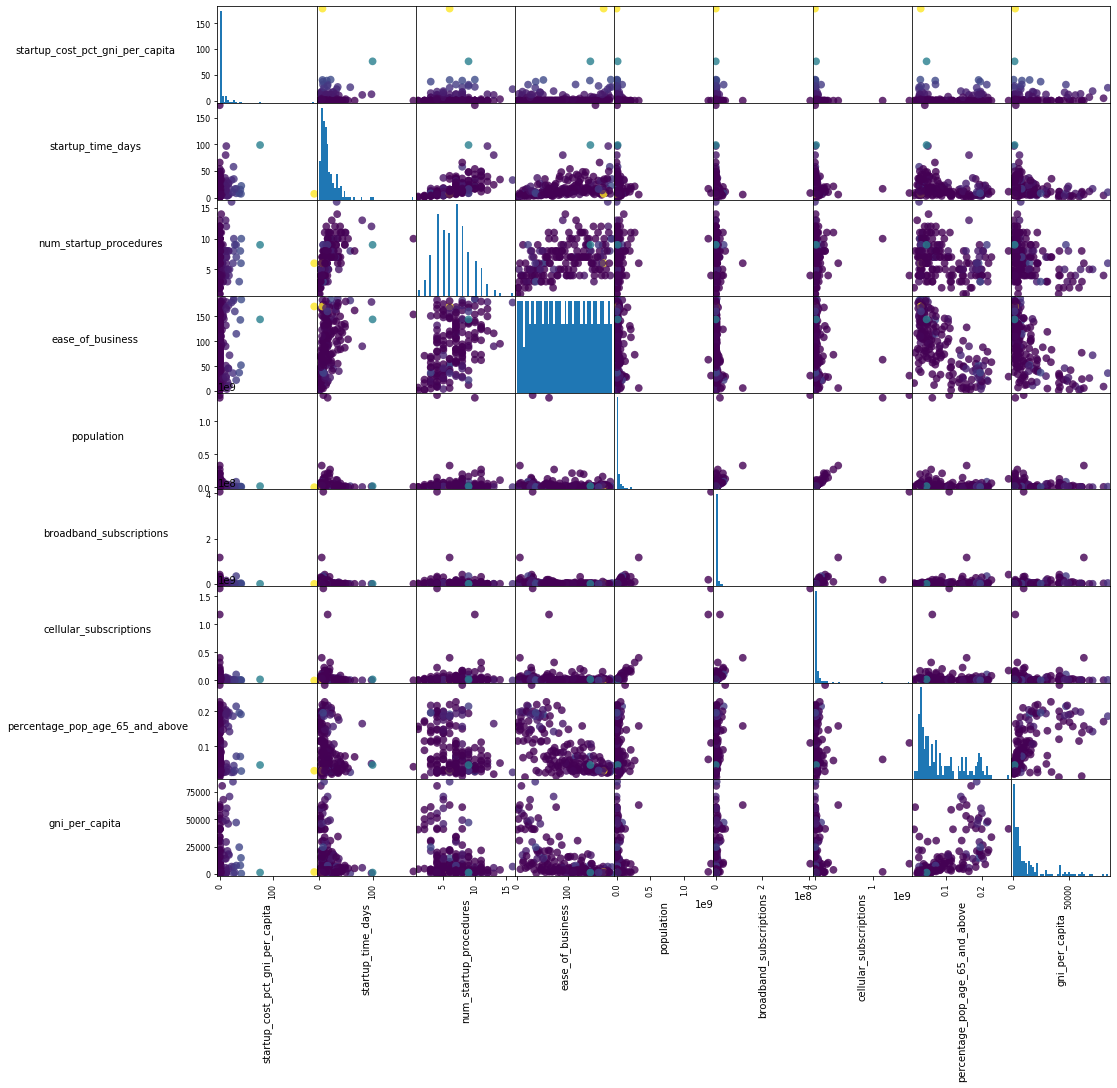

In [1101]:
# create a scatter matrix from the dataframe, color by y_train
Y = np.array(df_join3['startup_cost_pct_gni_per_capita'])
grr = pd.plotting.scatter_matrix(df_join3.drop(['country_name'], axis=1), c=Y,figsize=(16, 16), marker='o',
                                 hist_kwds={'bins': 50}, s=60, alpha=.8)
n = len(df_join3.columns)-1
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = grr[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 100

#### Check correlations
The correlation coefficients are small so there is little association between the variables. I will still try using a linear regression model

In [1037]:
corr_matrix = df_join3.corr()
corr_matrix['startup_cost_pct_gni_per_capita'].sort_values(ascending=False)

startup_cost_pct_gni_per_capita    1.000000
ease_of_business                   0.149119
startup_time_days                  0.089883
num_startup_procedures             0.054970
gni_per_capita                     0.021536
percentage_pop_age_65_and_above    0.004999
broadband_subscriptions           -0.037797
population                        -0.061602
cellular_subscriptions            -0.062651
Name: startup_cost_pct_gni_per_capita, dtype: float64

### Linear Regression

#### Split the dataset into training and test sets

In [1085]:
X = df_join3.drop(['country_name','startup_cost_pct_gni_per_capita'], axis=1)
Y = np.array(df_join3['startup_cost_pct_gni_per_capita'])

from sklearn.model_selection import train_test_split
np.random.seed()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

#### Get predictions

In [1086]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

#### Fitted Coefficients 

In [1087]:
# input_feature_names = ['Startup Time', 'Startup Procedures', 'GNI', 'GDP Per Capita', 'Business Regulation', 'Ease of business']
input_feature_names = X_train.columns

coef_dict = {input_feature_names[i]: reg.coef_[i] for i in range(0, len(input_feature_names))}

Text(0.5, 0, 'Coefficients')

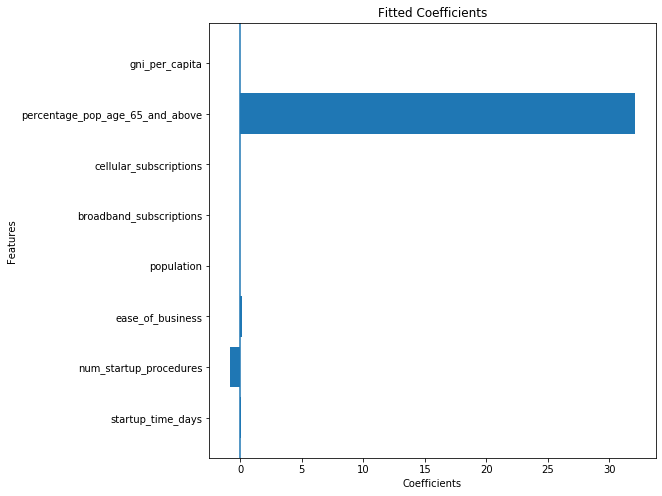

In [1088]:
plt.figure(figsize=(8,8))
plt.barh(range(len(coef_dict)), list(coef_dict.values()), align='center', tick_label=list(coef_dict.keys()))
plt.axvline(x=0)
plt.title("Fitted Coefficients")
plt.ylabel('Features')
plt.xlabel('Coefficients')

#### Evaluate model errors

Text(0.5, 1.0, 'Test Set')

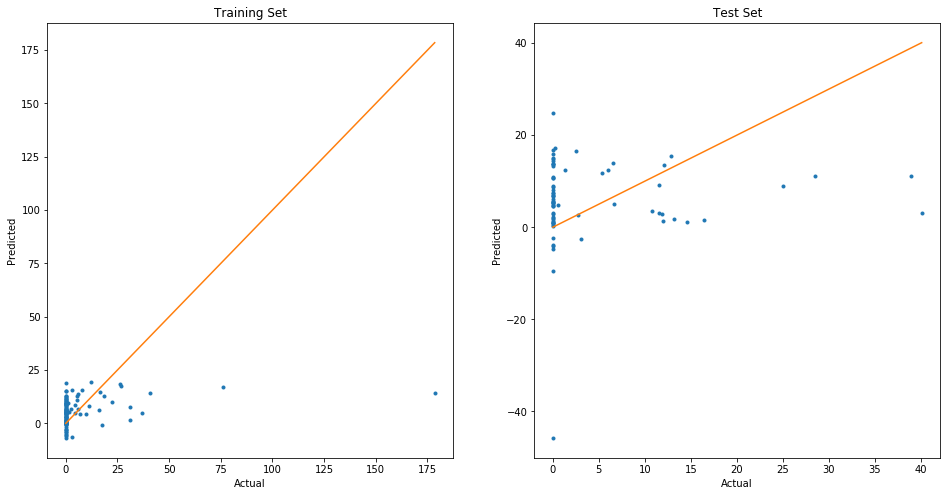

In [1089]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(y_train, y_pred, '.')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Set')

plt.subplot(1,2,2)
plt.plot(y_test, y_test_pred, '.')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Set')

#### Some reasons for the test error to be lower than the train error could be that the variables have no linear correlation with each other, the dataset is noisy, or the dataset size is small. The methods after this perform better

In [1090]:
from sklearn.metrics import mean_squared_error
print('Root mean squared error for training set: ' + str(round(np.sqrt(mean_squared_error(y_train, y_pred)))))
print('Root mean squared error for test set: ' + str(round(np.sqrt(mean_squared_error(y_test, y_test_pred)))))

Root mean squared error for training set: 19.0
Root mean squared error for test set: 12.0


### Random Forest

#### Get predictions

In [1091]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train,y_train)
y_pred_rf = rf_reg.predict(X_train)
y_test_pred_rf = rf_reg.predict(X_test)

#### Feature Importance plot 

In [1092]:
input_feature_names = train.drop(['country_name', 'Startup Cost Pct of GNI'], axis=1).columns
fe_dict = {input_feature_names[i]: rf_reg.feature_importances_[i] for i in range(0, len(input_feature_names))}

Text(0.5, 0, 'Importance')

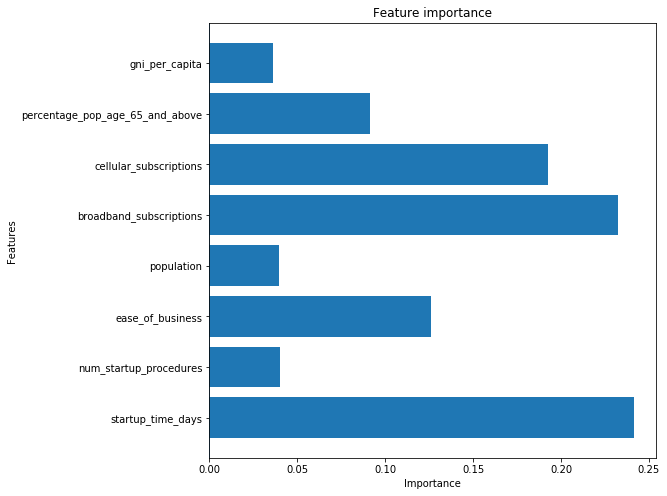

In [1093]:
plt.figure(figsize=(8,8))
plt.barh(range(len(fe_dict)), list(fe_dict.values()), align='center', tick_label=list(coef_dict.keys()))
plt.axvline(x=0)
plt.title("Feature importance")
plt.ylabel('Features')
plt.xlabel('Importance')

#### Evaluate model errors

Text(0.5, 1.0, 'Test Set')

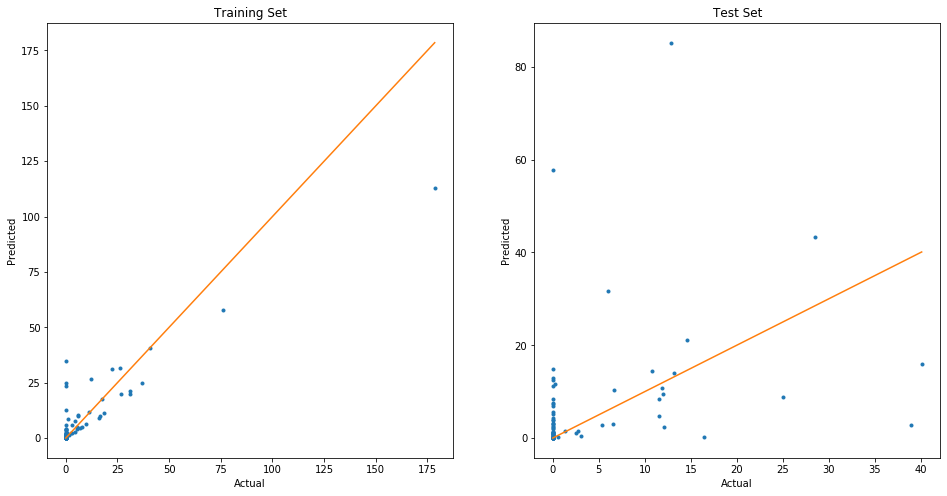

In [1094]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(y_train, y_pred_rf, '.')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Set')

plt.subplot(1,2,2)
plt.plot(y_test, y_test_pred_rf, '.')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Set')

In [1095]:
print('Root mean squared error for training set: ' + str(round(np.sqrt(mean_squared_error(y_train, y_pred_rf)))))
print('Root mean squared error for test set: ' + str(round(np.sqrt(mean_squared_error(y_test, y_test_pred_rf)))))

Root mean squared error for training set: 9.0
Root mean squared error for test set: 14.0


### Gradient Boosting

#### Get predictions

In [1096]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
y_pred_test = model.predict(X_test)

#### Feature Importance plot

In [1097]:
input_feature_names = train.drop(['country_name', 'Startup Cost Pct of GNI'], axis=1).columns
fe_dict = {input_feature_names[i]: model.feature_importances_[i] for i in range(0, len(input_feature_names))}

Text(0.5, 0, 'Importance')

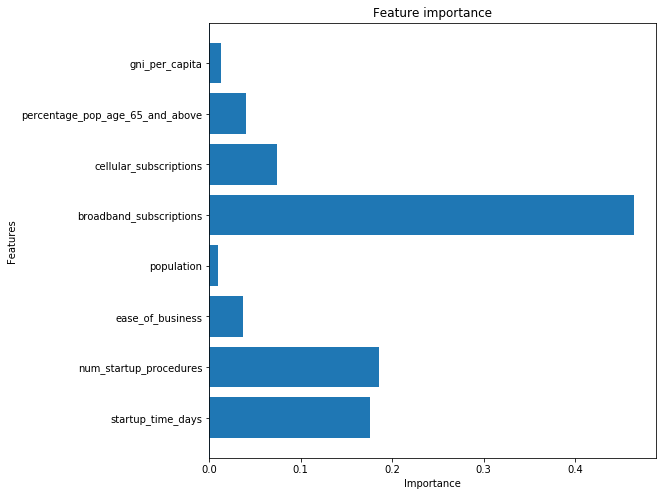

In [1098]:
plt.figure(figsize=(8,8))
plt.barh(range(len(fe_dict)), list(fe_dict.values()), align='center', tick_label=list(coef_dict.keys()))
plt.axvline(x=0)
plt.title("Feature importance")
plt.ylabel('Features')
plt.xlabel('Importance')

#### Evaluate model errors

Text(0.5, 1.0, 'Test Set')

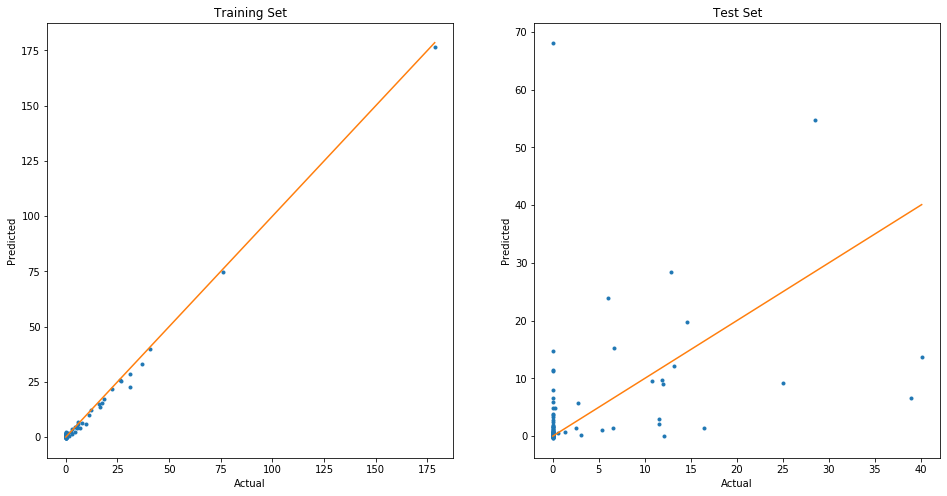

In [1099]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(y_train, y_pred, '.')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Set')

plt.subplot(1,2,2)
plt.plot(y_test, y_pred_test, '.')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Set')

In [1100]:
print('Root mean squared error for training set: ' + str(round(np.sqrt(mean_squared_error(y_train, y_pred)))))
print('Root mean squared error for test set: ' + str(round(np.sqrt(mean_squared_error(y_test, y_pred_test)))))

Root mean squared error for training set: 1.0
Root mean squared error for test set: 11.0


#### Using the RMSE to judge the models, I would pick the gradient boosted model. Since both training and test errors are improving, it is less likely to be overfitting